# Analysing Model Predictions

In this notebook, the model predictions from *ClassificationNanoparticles.ipynb* and *RegressionNanoparticles.ipynb* can be plotted and analysed. The main data to be analysed is the model's accuracy as the angle interval differs in the training and test dataset.

All of my work can be found at https://github.com/javidahmed64592/Y4-Nanoparticles-Project.

# Importing the relevant libraries.

In [9]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt

The data is loaded from and saved directly in Google Drive.

In [10]:
from google.colab import drive
drive_path = "/content/drive"
drive.mount(drive_path, force_remount=True)

cwd = os.path.join(drive_path, "MyDrive", "Nanoparticles")
folder_name = "Tetrahedrons Centred W 11-11 RX 0-45 RY 0-45"
direc = os.path.join(cwd, folder_name)

Mounted at /content/drive


# Analysing the model's accuracy.

First, the desired model, classification or regression, must be chosen to load in the correct .csv file.

In [11]:
model_types = ["Classification", "Regression"]
model_to_analyse = model_types[0]
results_direc = os.path.join(direc, "Results", "%s Results" % model_to_analyse)

results_name = "%s Results.csv" % model_to_analyse
results_csv = os.path.join(results_direc, results_name)

The data is loaded in and converted to NumPy arrays.

In [12]:
results = []
configs = []

with open(results_csv, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        results.append(row)
        config = [row[0], row[1]]
        if config not in configs:
          configs.append(config)

results.pop(0)
configs.pop(0)
results = np.asarray(results).astype(float)
configs = np.asarray(configs).astype(float)
results[:, [0, 1]] = results[:, [1, 0]]
configs[:, [0, 1]] = configs[:, [1, 0]]

In [13]:
avg_results = []

for config in configs:
  counter = 0
  data = []
  for result in results:
    if np.array_equal(config, result[0:2]):
      data.append(result)
    
  data = np.asarray(data)
  avg_data = np.mean(data, axis=0)
  avg_results.append(avg_data)

avg_results = np.asarray(avg_results)

The data is then sorted in order of increasing angle step.

In [14]:
order = np.lexsort((avg_results[:,1], avg_results[:,0]))
avg_results_ordered = avg_results[order]

num_dr_train = np.unique(avg_results_ordered[:,0]).shape[0]
num_dr_test = np.unique(avg_results_ordered[:,1]).shape[0]

avg_results_ordered = np.reshape(avg_results_ordered, (num_dr_train, num_dr_test, avg_results_ordered.shape[-1]))

# Visualising the model's accuracy.

The average absolute differences between the true and predicted angles are plotted versus different training and test angle intervals, separeted into angle around the x-axis and y-axis.

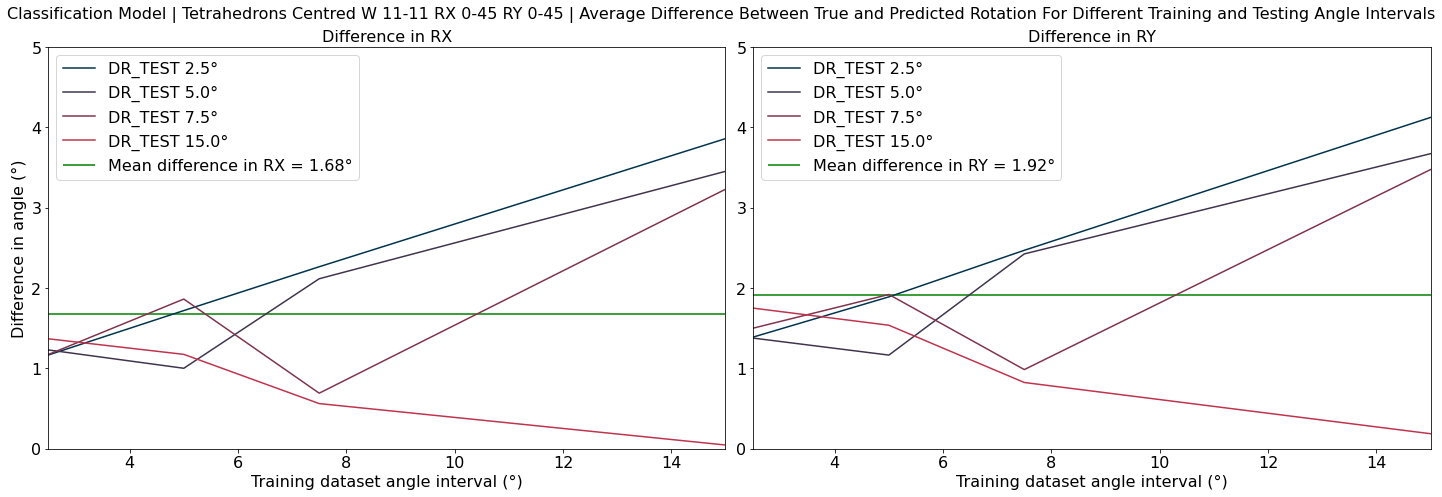

In [19]:
drx = []
dry = []

fig = plt.figure(figsize=(20, 7))

plt.subplot(121)

for index in range(avg_results_ordered.shape[0]):
  rx = avg_results_ordered[index][:,2]
  plt.plot(avg_results_ordered[index][:,1], rx, c=(index / avg_results_ordered.shape[0], 0.2, 0.3), label='DR_TEST %s°' % avg_results_ordered[index][0][0])
  drx.append(rx)

drx = np.asarray(drx)
plt.hlines(np.mean(drx), np.min(avg_results[:,1]), np.max(avg_results[:,1]), colors='g', label="Mean difference in RX = %s°" % round(np.mean(drx), 2))
plt.xlabel("Training dataset angle interval (°)", fontsize=16)
plt.ylabel("Difference in angle (°)", fontsize=16)
plt.xlim([np.min(avg_results_ordered[0][:,1]), np.max(avg_results_ordered[0][:,1])])
plt.ylim([0, 5])
plt.legend(loc='best', fontsize=16)
plt.title("Difference in RX", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(122)

for index in range(avg_results_ordered.shape[0]):
  ry = avg_results_ordered[index][:,3]
  plt.plot(avg_results_ordered[index][:,1], ry, c=(index / avg_results_ordered.shape[0], 0.2, 0.3), label='DR_TEST %s°' % avg_results_ordered[index][0][0])
  dry.append(ry)

dry = np.asarray(dry)
plt.hlines(np.mean(dry), np.min(avg_results[:,1]), np.max(avg_results[:,1]), colors='g', label="Mean difference in RY = %s°" % round(np.mean(dry), 2))
plt.xlabel("Training dataset angle interval (°)", fontsize=16)
plt.xlim([np.min(avg_results_ordered[0][:,1]), np.max(avg_results_ordered[0][:,1])])
plt.ylim([0, 5])
plt.legend(loc='best', fontsize=16)
plt.title("Difference in RY", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.suptitle("%s Model | %s | Average Difference Between True and Predicted Rotation For Different Training and Testing Angle Intervals" % (model_to_analyse, folder_name), fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.90)

plt.show()

The above graph is saved to Google Drive.

In [20]:
plot_name = "%s Results.png" % model_to_analyse
fig.savefig(os.path.join(results_direc, plot_name))